## 0 - Librairies

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'torch'
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
#choose kernel (keras-env) when run on Macbook Pro 
import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import torch
from datetime import datetime
import calendar
import random
import speasy as spz
from speasy import amda 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import toml
import h5py
import joblib
plt.style.use('custom_style.mplstyle')

## 0 - Functions

In [2]:
def E_mhd(df):
    '''
    [B] = nT
    [u] = km/s
    [E] = µV/m => mV/m
    '''
    dg = pd.DataFrame(index=df.index,columns=['ex','ey','ez'])
    dg['ex']=(df['by']*df['uz']-df['uy']*df['bz'])/1e3
    dg['ey']=(df['bz']*df['ux']-df['uz']*df['bx'])/1e3 #MINUS SIGN TO FIT MEASUREMENTS IN MMS1 MAYBE THERE IS A ISSUE WITH THE MEASUREMENT TOOL IN MMS1
    dg['ez']=(df['bx']*df['uy']-df['ux']*df['by'])/1e3
    return dg

def E_hall(df):
    '''
    [B] = nT
    [j] = A/m^2
    [n] = cm^-3
    [E] = *1e-15 V/m => 1e-12 mV/m
    '''
    dg = pd.DataFrame(index=df.index,columns=['ex','ey','ez'])
    dg['ex']= ((df['jy']*df['bz']-df['by']*df['jz'])/(e*df['e_density']))/1e12
    dg['ey']= ((df['jz']*df['bx']-df['bz']*df['jx'])/(e*df['e_density']))/1e12
    dg['ez']= ((df['jx']*df['by']-df['bx']*df['jy'])/(e*df['e_density']))/1e12
    return dg

## 1 - Config

In [3]:
config = toml.load('model_config.toml')
seed = config['stat']['seed']
t1 = config['data']['t1']
t2 = config['data']['t2']
sat = config['data']['sat']
density_threshold = config['data']['density_threshold']
name = config['model']['name']
f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
shuffle = config['model']['shuffle']
PINNS = config['model']['PINNS']

## 1 - Seeding

In [4]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed)
# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
# 4. Set the `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed)
torch.use_deterministic_algorithms(mode=False)

## 2 - Data Loading

In [5]:
sat = 'mms1'

In [6]:
e = 1.602176634e-19
m_i = 1.67262192369e-27
m_e = 9.1093837015e-31
## Global interval - all the data will be inside this range
## Loading data
file = h5py.File('./data.hdf5','r')
bursts = list(file[f"{sat}"].keys())
file.close()

#bursts = [datetime.strptime(burst, f'/{sat}/%Y_%m_%dT%H_%M_%S') for burst in bursts]
bursts = pd.DataFrame(bursts)

bursts = bursts.where((str(t1.date()) < bursts)&(bursts < str(t2.date()))).dropna()

df = pd.concat([pd.read_hdf('./data.hdf5',key=f"{sat}/{event[0]}") for event in bursts.values]).dropna()
df['ux']=(m_i*df['vx_i']+m_e*df['vx_e'])/(m_i+m_e)
df['uy']=(m_i*df['vy_i']+m_e*df['vy_e'])/(m_i+m_e)
df['uz']=(m_i*df['vz_i']+m_e*df['vz_e'])/(m_i+m_e)
df = df.where(df['e_density']>density_threshold).dropna()

if PINNS:
    df[['ex_mhd','ey_mhd','ez_mhd']] = E_mhd(df)
    df[['ex_hall','ey_hall','ez_hall']] = E_hall(df)
    ## Input / Output wanted
    input_features = ['bx', 'by', 'bz',
                'jx', 'jy', 'jz',
                'ux', 'uy', 'uz',
                'ex_mhd','ey_mhd','ez_mhd',
                'ex_hall','ey_hall','ez_hall',
                'e_density',]
    output_targets = ['ex','ey','ez']
else:
    ## Input / Output wanted
    input_features = ['bx', 'by', 'bz',
                'jx', 'jy', 'jz',
                'ux', 'uy', 'uz',
                'e_density',]
    output_targets = ['ex','ey','ez']

df = df.drop(df.columns.drop(input_features+output_targets),axis=1)
df = df[input_features + output_targets] #reorder columns for input to the left and output to the right
df0 = df

## 3 - Train, validation, test intervals

In [7]:
## Train interval 
id_train_beg = 0
id_train_end = int(len(df.index)*(f_train))

t_train_begin = df.index.values[0]
t_train_end = df.index.values[id_train_end]
print("Train interval: ", t_train_begin, t_train_end)

## Validation interval


id_val_beg = id_train_end+1
id_val_end = int(len(df.index)*(f_train+f_valid))
t_val_begin = df.index.values[id_val_beg]
t_val_end = df.index.values[id_val_end]
print("Validation interval: ", t_val_begin, t_val_end)

## Test interval 
id_test_beg = id_val_end + 1
id_test_end =  int(len(df.index))-1
t_test_begin = df.index.values[id_test_beg]
t_test_end = df.index.values[id_test_end]
print("Test interval: ", t_test_begin, t_test_end)


df_train, df_test = train_test_split(df,test_size = f_test+f_valid,train_size=f_train,random_state=seed,shuffle=shuffle)
df_val, df_test = train_test_split(df_test,test_size= f_test/(f_test+f_valid), random_state=seed, shuffle=shuffle)
#df_val, df_test = df_test.iloc[:len(df_test)//2,:], df_test.iloc[len(df_test)//2:,:]

Train interval:  2015-09-01T12:11:14.015000000 2015-12-03T09:47:12.815000000
Validation interval:  2015-12-03T09:47:12.845000000 2015-12-15T11:03:26.731000000
Test interval:  2015-12-15T11:03:26.761000000 2015-12-31T23:45:43.963000000


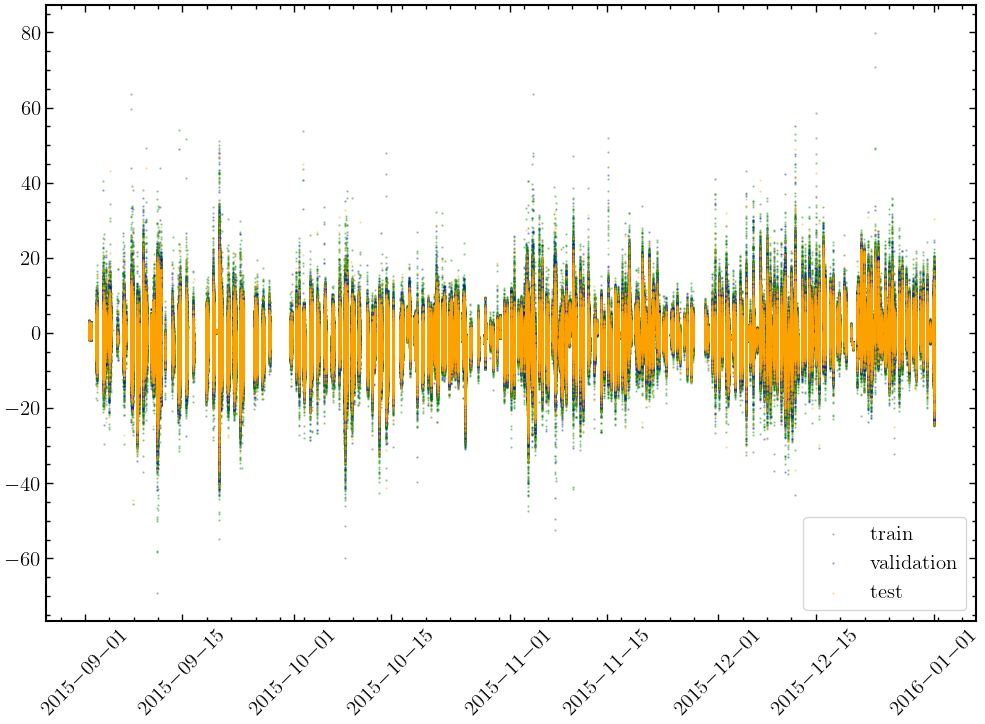

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.scatter(df_train.index,df_train['ex'],s=0.5, rasterized=True, color='green', label='train',alpha=0.33)
ax.scatter(df_val.index,df_val['ex'],s=0.5, rasterized=True, color='blue', label='validation',alpha=0.33)
ax.scatter(df_test.index,df_test['ex'],s=0.5, rasterized=True, color='orange', label='test',alpha=0.33)
plt.xticks(rotation=45)
plt.legend()

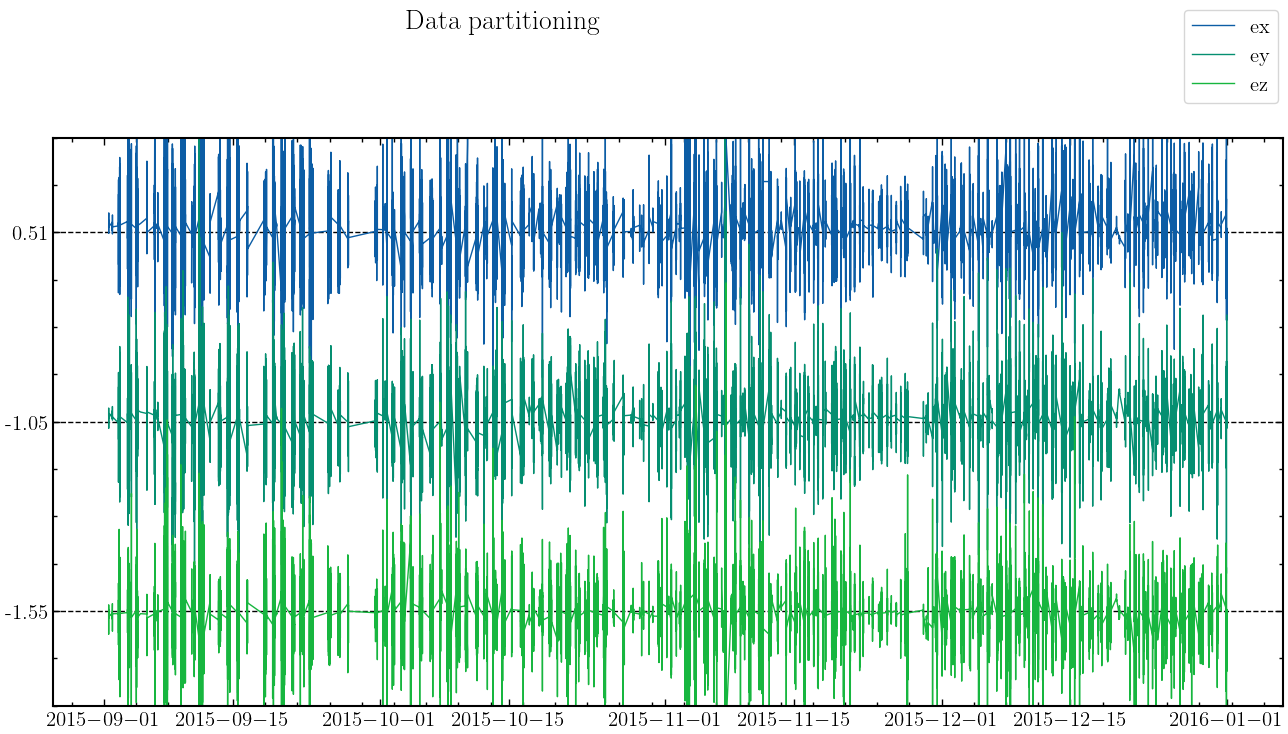

In [9]:
def f(X,mid):
    Y = mid + (X - X.mean()) / (X.max() - X.min())
    return Y
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.25)

#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_train_beg],xmax=df.index[id_train_end],label='train',color='green',alpha=0.5)
#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_val_beg],xmax=df.index[id_val_end],label='validation',color='blue',alpha=0.5)
#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_test_beg],xmax=df.index[id_test_end],label='test',color='orange',alpha=0.5)

mids = 1*(np.linspace(0,1,4)[1:]+np.linspace(0,1,4)[:-1])/2

ax.axhline(mids[0],color='black',linestyle='--')
ax.axhline(mids[1],color='black',linestyle='--')
ax.axhline(mids[2],color='black',linestyle='--')
ax.plot(df.index.values,1*f(df['ex'],mids[-1]),label='ex')
ax.plot(df.index.values,1*f(df['ey'],mids[-2]),label='ey')
ax.plot(df.index.values,1*f(df['ez'],mids[-3]),label='ez')

ax.set_yticks(mids,[f'{df[e].mean():.2f}' for e in ['ex','ey','ez']])
ax.set_ylim(0,1)
fig.legend()

fig.subplots_adjust(top=0.82)
fig.subplots_adjust(right=1.15)
fig.suptitle("Data partitioning", fontsize=20)

plt.show()

## 4 - Scaling

In [27]:
## Define a scaler function
scaler = joblib.load(f'../Saved_models/{name}/scaler.save')
## Obtain scaler based on the “train” data
df_train_scaled = scaler.transform(df_train)
## Apply the scaling obtained from the “train” data to “validation” and “test” data
df_val_scaled = scaler.transform(df_val)
df_test_scaled = scaler.transform(df_test)

In [12]:
## Get input 'X'
X_train = df_train_scaled[:,0:len(input_features)]
X_test = df_test_scaled[:,0:len(input_features)]
X_val = df_val_scaled[:,0:len(input_features)]
## Get output 'y'
y_train = df_train_scaled[:,len(input_features):len(input_features)+len(output_targets)]
y_test = df_test_scaled[:,len(input_features):len(input_features)+len(output_targets)]
y_val = df_val_scaled[:,len(input_features):len(input_features)+len(output_targets)]

## 5 - Model loading and prediction

In [13]:
# Recreate the exact same model, including its weights and the optimizer
model = keras.models.load_model(f'../Saved_models/{name}/model.keras')

# Show the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 16)               │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 128)              │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 3)                │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,579 (420.23 KB)

 Trainable params: 35,859 (140.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 71,720 (280.16 KB)

In [14]:
test_predict = model.predict(X_test)

35417/35417 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step


In [15]:
print('Test 1', t_test_begin, t_test_end)

score_test = model.evaluate(X_test, y_test, verbose=0)
print('\nLoss score = ', score_test)

mse_test = []
for i in range(y_test.shape[1]):
    mse_test.append(mean_squared_error(y_test[:,i], test_predict[:,i]))
print('\nMSE of all targets = ', mse_test)

Pcc_xyz_test = []
for i in range(y_test.shape[1]):
    Pcc_xyz_test.append(round(np.corrcoef(y_test[:,i], test_predict[:,i])[0,1],3))
print('\nPcc of all targets = ', Pcc_xyz_test)

r2_xyz_test = []
for i in range(y_test.shape[1]):
    r2_xyz_test.append(round(r2_score(y_test[:,i], test_predict[:,i]),3))
print('\nr2 of all targets = ', r2_xyz_test)


Test 1 2015-12-15T11:03:26.761000000 2015-12-31T23:45:43.963000000

Loss score =  0.016386667266488075

MSE of all targets =  [8.258510061658396e-05, 0.0031106296259401285, 8.048440905841211e-05]

Pcc of all targets =  [0.955, -0.857, 0.888]

r2 of all targets =  [0.912, -3.017, 0.785]


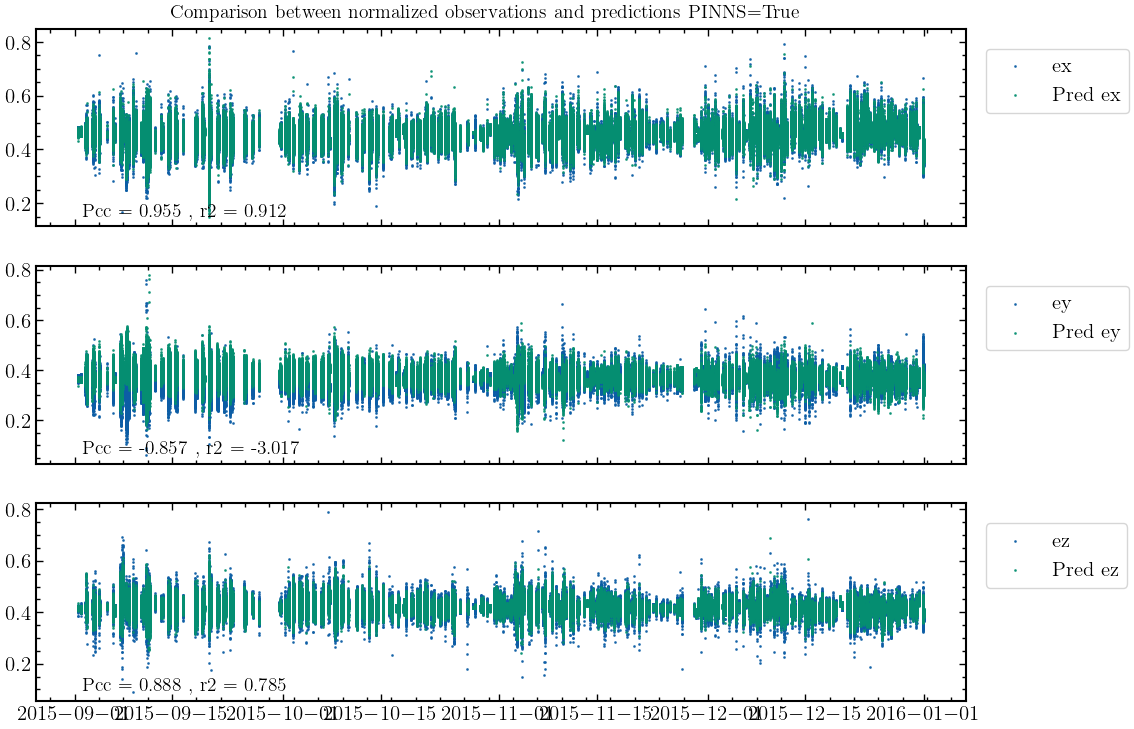

In [16]:
fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8),facecolor='white')
plt.subplots_adjust(hspace=0.2)
#plt.style.use('ggplot')

target_labels = output_targets

for i in range(y_test.shape[1]):
    ax[i].scatter(df_test.index,y_test[:,i],s=1, rasterized=True, label=target_labels[i],alpha=0.8)
    ax[i].scatter(df_test.index,test_predict[:,i],s=1, rasterized=True, label='Pred {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_theo_scale[test_ind_begin:test_ind_end,i], label='Theo {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_mhd_scale[test_ind_begin:test_ind_end,i], label='MHD {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_hall_scale[test_ind_begin:test_ind_end,i], label='Hall {}'.format(target_labels[i]),alpha=0.8)
    ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
    text = str('Pcc = {}'.format(Pcc_xyz_test[i])) + str(' , r2 = {}'.format(r2_xyz_test[i]))
    ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
    
for i in range(y_test.shape[1]-1):
    plt.setp(ax[i].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.95)
fig.suptitle(f"Comparison between normalized observations and predictions PINNS={PINNS}", fontsize=14)

plt.show()

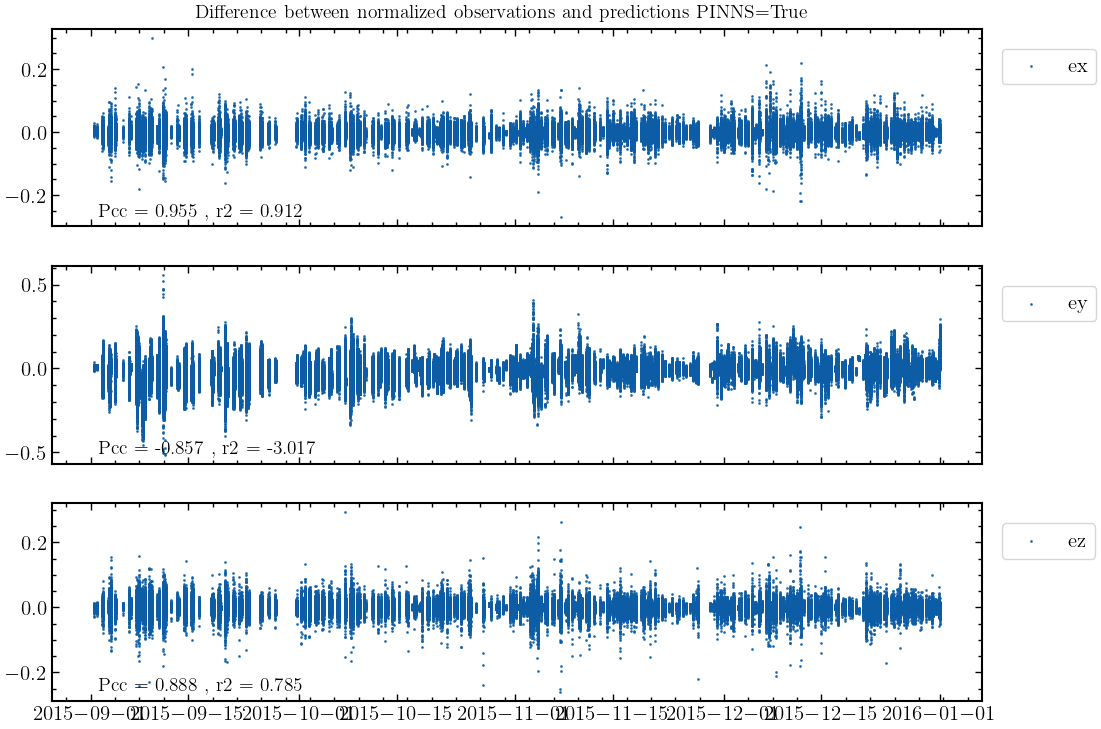

In [17]:
fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8),facecolor='white')
plt.subplots_adjust(hspace=0.2)
#plt.style.use('ggplot')

target_labels = output_targets

for i in range(y_test.shape[1]):
    ax[i].scatter(df_test.index, y_test[:,i]-test_predict[:,i],s=1,rasterized=True, label=target_labels[i],alpha=0.8)
    #ax[i].plot(d_theo_scale[test_ind_begin:test_ind_end,i], label='Theo {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_mhd_scale[test_ind_begin:test_ind_end,i], label='MHD {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_hall_scale[test_ind_begin:test_ind_end,i], label='Hall {}'.format(target_labels[i]),alpha=0.8)
    ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
    text = str('Pcc = {}'.format(Pcc_xyz_test[i])) + str(' , r2 = {}'.format(r2_xyz_test[i]))
    ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
    
for i in range(y_test.shape[1]-1):
    plt.setp(ax[i].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.95)
fig.suptitle(f"Difference between normalized observations and predictions PINNS={PINNS}", fontsize=14)

plt.show()

In [18]:
# test
predict_scaled = np.concatenate((X_test[:,:],test_predict), axis=1)
print(predict_scaled.shape)
print(predict_scaled)
# test 
predict = scaler.inverse_transform(predict_scaled)
print(predict)
print(predict.shape)

(1133313, 19)
[[0.53248339 0.5577119  0.62187898 ... 0.40119752 0.40294901 0.45694077]
 [0.57589115 0.31860672 0.36350564 ... 0.48256475 0.34291279 0.4024885 ]
 [0.58133174 0.52408329 0.60137434 ... 0.44292292 0.35053152 0.42770779]
 ...
 [0.60707646 0.42495869 0.70045166 ... 0.44361839 0.36039144 0.42451549]
 [0.57771983 0.34408806 0.55328506 ... 0.4980627  0.35256794 0.41422123]
 [0.6174023  0.43875535 0.75017423 ... 0.41900939 0.37556565 0.43157357]]
[[ -0.32972025  25.70840979  27.43389034 ...  -9.36030108   5.05810096
    5.0143205 ]
 [  7.29102886 -23.43983889 -34.25313187 ...   2.77181643  -3.20059399
   -2.06260835]
 [  8.24618959  18.79602385  22.53837681 ...  -3.13890881  -2.15254772
    1.21503518]
 ...
 [ 12.76598191  -1.57911131  46.19323444 ...  -3.03521243  -0.79619853
    0.80014487]
 [  7.61207569 -18.20213127  11.05698919 ...   5.08261153  -1.87241359
   -0.53775593]
 [ 14.57880592   1.25680098  58.06457329 ...  -6.7044942    1.29119452
    1.71745388]]
(1133313, 19)


In [19]:
# test 
df_predict = pd.DataFrame(predict)
df_predict.columns = df0.columns
df_predict['time'] = df_test.index
df_predict = df_predict.set_index(['time'])
df_predict

,bx,by,bz,jx,jy,jz,ux,uy,uz,ex_mhd,ey_mhd,ez_mhd,ex_hall,ey_hall,ez_hall,e_density,ex,ey,ez
time,,,,,,,,,,,,,,,,,,,
2015-11-08 14:17:44.820,-0.329720,25.708410,27.433890,-2.384766e-08,5.389281e-09,-3.025988e-08,-217.254464,231.658748,-178.388417,-10.941383,-6.018953,5.508884,0.753506,0.540610,-0.497552,7.668526,-9.360301,5.058101,5.014320
2015-10-18 06:51:36.274,7.291029,-23.439839,-34.253132,1.144786e-07,3.803783e-07,3.299392e-07,-118.698525,108.053041,21.851469,3.188960,3.906477,-1.994456,-0.396529,0.473763,-0.408606,83.351936,2.771816,-3.200594,-2.062608
2015-09-18 12:07:45.356,8.246190,18.796024,22.538377,9.966040e-08,1.368845e-07,1.796611e-07,53.530841,87.206823,-8.835720,-2.131577,1.279359,-0.287043,-1.696344,-4.445873,4.328312,1.073503,-3.138909,-2.152548,1.215035
2015-12-30 23:31:37.368,7.604087,-16.233230,46.890026,-1.510755e-08,-9.630341e-10,-1.357896e-08,-0.530658,91.328347,-85.855035,-2.888684,0.627967,0.685854,-1.511690,3.444373,1.437583,1.096564,-3.182812,0.786018,1.066909
2015-10-08 08:56:54.275,-4.186301,8.976827,-4.202290,-7.656262e-08,2.399771e-08,-8.211029e-08,-175.999661,236.337531,-2.988794,0.966329,0.727090,0.590538,0.269057,0.009303,-0.248160,14.759408,1.114274,-0.278403,0.257704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-22 17:06:33.537,29.858585,-21.320964,22.468514,-2.628005e-08,2.094899e-08,-2.401026e-08,-239.402395,218.773605,41.615241,-5.802795,-6.621588,1.427980,-0.053170,-0.163059,-0.084073,4.839756,-5.935347,6.731227,1.019880
2015-12-06 23:55:21.693,-11.875736,23.460560,-37.281146,-9.034228e-08,9.174296e-08,8.876054e-08,-89.620306,-20.234448,-58.413953,-2.124787,2.647439,2.342842,-1.746664,-1.403691,-0.326934,19.663124,-3.399141,-3.205423,1.988289
2015-11-22 11:48:43.671,12.765982,-1.579111,46.193234,4.553850e-08,-6.346561e-09,1.373006e-08,-6.779941,54.441961,-24.360682,-2.476382,-0.002199,0.684299,-0.593511,-4.215538,0.019915,2.855023,-3.035212,-0.796199,0.800145


In [20]:
df_theo = E_mhd(df_test)+E_mhd(df_test)

In [21]:
df_predict['ey'] = - df_predict['ey']

In [23]:
name

'DNN_XL_SP_0'

In [ ]:
f'../Saved_models/{name}/

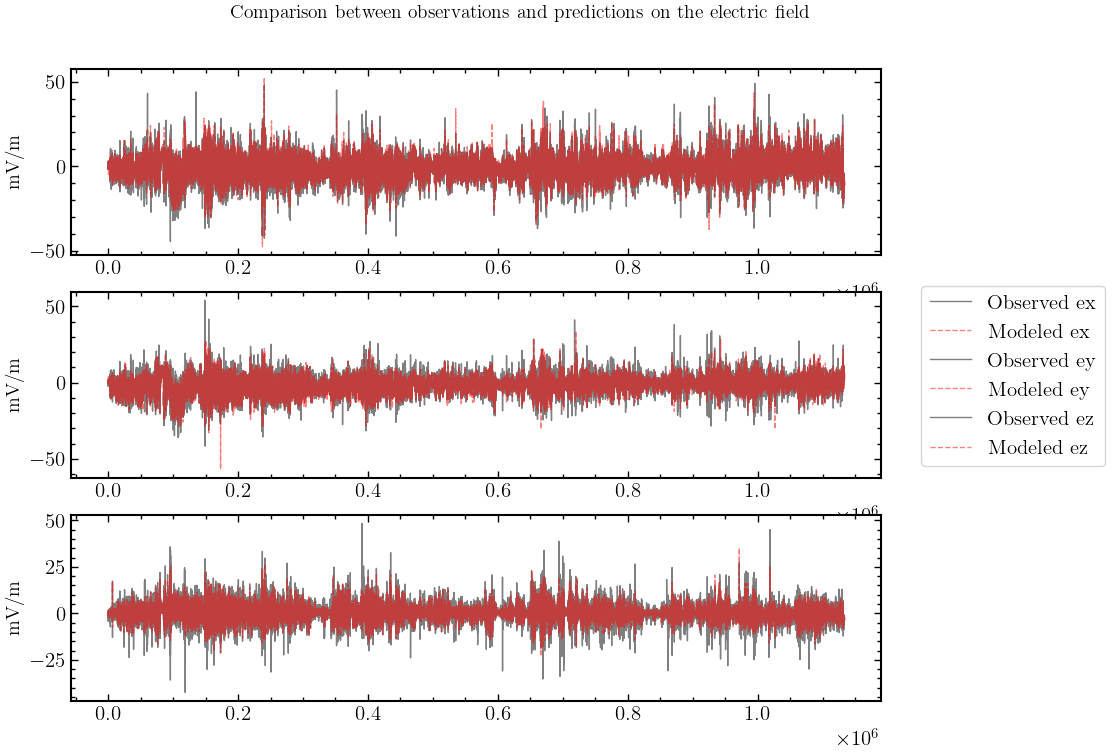

In [22]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        ax[j].plot(np.arange(len(df_test)),df_test.sort_index()[col], label='Observed ' + col, color='k',linestyle='solid',alpha=0.5)
        ax[j].plot(np.arange(len(df_test)),df_predict.sort_index()[col], label='Modeled ' + col, color='r',linestyle='dashed',alpha=0.5)
        #ax[j].plot(np.arange(len(df_test)),df_theo.sort_index()[col], label="Ohm's law " + col, color='g',linestyle='dotted',alpha=0.5)
        #ax[j].plot(d_mhd[col+'_mhd'], label='MHD ' + col, color='g')
        #ax[j].plot(d_hall[col+'_hall'], label='Hall ' + col, color='b')
        #ax[j].legend(loc='upper left',bbox_to_anchor=(.01, 1.0),ncols=2, fontsize=12)
        #ax[j].set_xlim(t_test_begin, t_test_end)
        #ax[j].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        #ax[j].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
        #ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        #ax[j].set_xlim(6700,6900)
        ax[j].set_ylabel('mV/m', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        #text = str('Pcc = {}'.format(Pcc_xyz[j])) + str(' , r$^2$ = {}'.format(r2_xyz[j]))
        #ax[j].text(0.75, 0.05, text, fontsize=14, transform=ax[j].transAxes)

#ax[0].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[0]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[0]].max() + 10)
#ax[1].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[1]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[1]].max() + 10)
#ax[2].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[2]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[2]].max() + 10)
    
fig = plt.gcf()
fig.legend(loc='center right')
fig.subplots_adjust(top=0.9,right=0.8)
fig.suptitle("Comparison between observations and predictions on the electric field", fontsize=14)

plt.show()

In [ ]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        ax[j].plot(df_test.sort_index()[col]-df_predict.sort_index()[col], label='Diff ' + col, color='k')
        #ax[j].plot(d_mhd[col+'_mhd'], label='MHD ' + col, color='g')
        #ax[j].plot(d_hall[col+'_hall'], label='Hall ' + col, color='b')
        ax[j].legend(loc='upper left',bbox_to_anchor=(.01, 1.0),ncols=2, fontsize=12)
        ax[j].set_xlim(t_test_begin, t_test_end)
        ax[j].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax[j].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
        ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        ax[j].set_ylabel('mV/m', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        #text = str('Pcc = {}'.format(Pcc_xyz[j])) + str(' , r$^2$ = {}'.format(r2_xyz[j]))
        #ax[j].text(0.75, 0.05, text, fontsize=14, transform=ax[j].transAxes)

#ax[0].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[0]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[0]].max() + 10)
#ax[1].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[1]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[1]].max() + 10)
#ax[2].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[2]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[2]].max() + 10)
    
fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Comparison between observations and predictions on the electric field", fontsize=14)

plt.show()

In [ ]:
df_test[col].std()

In [ ]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        sns.histplot((df_test[col]-df_test[col].mean())/df_test[col].std(),ax=ax[j],stat='density',color='blue',alpha=0.8)
        sns.histplot((df_predict[col]-df_predict[col].mean())/df_predict[col].std(),ax=ax[j],stat='density',color='red',alpha=0.8)

"""
ax[0].set_xlim(-5,5)
ax[1].set_xlim(-5,5)
ax[2].set_xlim(-5,5)"""
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
Sscaler = StandardScaler()

In [ ]:
df_res = df_test[output_targets]-df_predict[output_targets]

In [ ]:
df_res_scaled = Sscaler.fit_transform(df_res)

In [ ]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        sns.histplot(df_res[col],ax=ax[j],stat='density',color='blue',alpha=0.8,label=col)

ax[0].set_xlim(-5,5)
ax[1].set_xlim(-5,5)
ax[2].set_xlim(-5,5)

plt.tight_layout()
plt.show()

In [ ]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        sns.histplot(df_res_scaled[:,j],ax=ax[j],stat='density',color='blue',alpha=0.8,label=col)


ax[0].set_xlim(-5,5)
ax[1].set_xlim(-5,5)
ax[2].set_xlim(-5,5)

plt.tight_layout()
plt.show()

In [ ]:
df.index[2643046]
df.iloc[2643046,:]

In [ ]:
df[output_targets].plot()

In [ ]:
df.iloc[2643046-100:2643046+100,:][output_targets].plot()

In [ ]:
df.iloc[2425204-1000:2425204+1000][output_targets].plot()

In [ ]:
df.iloc[2437606-100000:2437606+100000]['ez'].argmin()

In [ ]:
2437606-100000 + 87598